# Analysis of Ultimatum game to maximize an individuals payoff
**Original Study**
- Conducted by James Andreoni and Hal Varian

>Resources
- Full paper can be found here http://www.pnas.org/content/96/19/10933.full
- Attiyeh, G., Franciosi, R. & Isaac, R. M. (1999) Public Choice, in press.
- Bagnoli M, Ben-David S, McKee M(1992) J Public Econ 47:85–106.
-  Chen Y, Plott C R(1996) J Public Econ 59:335–364
- Jonathan Levin (2006) http://web.stanford.edu/~jdlevin/Econ%20286/Experimental.pdf

**Overview**
- The Ultimatum game is an extension of the classic economic thought experiment of Prisoner's Dilemma. To summarize, Prisoner's Dilemma is a situation between two people where each person has the option to defeat of cooperate. The traditional example is given in the following example. Imagine you were brought into a police station to be investigated for a crime. In the other room is your friend who was also being questioned. In the room, you have two options, defect and tell the officers that your friend commited the crime of cooperate with your friend and do no tell the police anything. You friend also has these options. The nash equilibirum is for both parties to stay silent. 
- Even with the nash equlibirum evident, studies have shown that even with incentives to cooperate subjects reach nash equilibirum 10% (Attiyeh et al.), around 20% ( Chen and Plott), and 54% (Bagnoli and McKee) of the time 

> Prionser's Dilemma outlined below

![alt text](prisoners_dilemma.jpg "Title")

**Ultimatum Game**
- The study expanded upon the traditional prisoner's dilemma by first training subjects on a variant of prisoner's dilemma called the ultimatum game. A brief overview of this game is as follows. Imagine you are sitting across the table from another person. In the middle of you is a pot of money. Each person is labeled of either Proposer or Responder. The Proposer can choose how to split the pot of money, while the Responder can decide whether to accept this split or reject this split. If the Responder accepts the split, both subjects receive money; however, if the Responder rejects the split than neither party receives any money.
- However, offers are rejected about 15-20% of the time (Levin).

![alt text](results_of_ultimatum.png "Title")


** Alternative to the game **
- This experiment used two stages; the first was a traditional ultimatum game, where as the second was the ultimatum game where subjects where allowed to offer a non-negative number to the other person to accept their offer. 
- In this study, participants were allowed to push (which meant giving the other person the amount of money represented by the number on the card) or pull (meaning you take the amount of money from the pot).
- Below is the screen the subjects saw when performing this study.
![alt text](game_setup.png "Title")

** Analysis**
- This project will used several machine learning techniques to see 
    - 1) How to maximize your own payoff (versus total payout) throught the different rounds of play
    - 2) Which factors are the most important to maximize your payoff (versus total payoff)
    - 3) Test the accuracy of different algorithms to answer the questions above.
- The is a supervised regression machine learning problem 
- The number of split for training and testing is determined by the user. The trainval split is used to create new train and validate splits. The train split is used to build the model, the validate is used to test the model, and this process is repeated from the initial split of trainval. Finally, the test split is used to evaluate the model (but this data is never used to build the model).

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model_testing import Model_Testing_Regression
%pylab inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from model_testing import Model_Testing_Regression
from  sklearn.ensemble import GradientBoostingRegressor
%load_ext autoreload
import xgboost
from scipy.spatial.distance import euclidean
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EDA on the data

In [264]:
cols = 'expernum,rd,time,sub,oppnt,myside,opptside,mypush,mypull,\
opptpush,opptpull,mychoice,opptchoice,mychoicecard,opptchoicecard,mypayoff,opptpayoff,totalpayoff'.split(',')

In [265]:
ultimatum_df = pd.read_table('preplay_data.txt',names=cols)

In [266]:
ultimatum_df.head()

,expernum,rd,time,sub,oppnt,myside,opptside,mypush,mypull,opptpush,opptpull,mychoice,opptchoice,mychoicecard,opptchoicecard,mypayoff,opptpayoff,totalpayoff
0,1,1,23,1,6,0,0,6,4,7,3,0,1,4,7,11,0,11
1,1,1,26,6,1,0,0,7,3,6,4,1,0,7,4,0,11,11
2,1,1,30,4,7,0,0,6,4,7,3,0,0,4,3,4,3,7
3,1,1,35,7,4,0,0,7,3,6,4,0,0,3,4,3,4,7
4,1,1,38,5,2,0,0,7,3,6,4,1,1,7,6,6,7,13


In [267]:
new_cols = 'expernum,rd,myside,opptside,mypush,mypull,\
opptpush,opptpull,mychoice,mychoicecard,mypayoff,opptpayoff,totalpayoff'.split(',')

- Remove the columns that are not meaningful for this analysis and columns that you would not see as a subject.
    - Sub (subject number)
    - oppnt (oppnt number)
    - time
    - opptchoice
    - opptchoice card

  

In [268]:
ultimatum_df = ultimatum_df.loc[:,new_cols]


In [269]:
ultimatum_df.head()

,expernum,rd,myside,opptside,mypush,mypull,opptpush,opptpull,mychoice,mychoicecard,mypayoff,opptpayoff,totalpayoff
0,1,1,0,0,6,4,7,3,0,4,11,0,11
1,1,1,0,0,7,3,6,4,1,7,0,11,11
2,1,1,0,0,6,4,7,3,0,4,4,3,7
3,1,1,0,0,7,3,6,4,0,3,3,4,7
4,1,1,0,0,7,3,6,4,1,7,6,7,13


In [270]:
ultimatum_df.describe()

,expernum,rd,myside,opptside,mypush,mypull,opptpush,opptpull,mychoice,mychoicecard,mypayoff,opptpayoff,totalpayoff
count,1920.00000,1920.000000,1920.000000,1920.000000,1920.00000,1920.00000,1920.00000,1920.00000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,3.50000,20.500000,2.093229,2.093229,6.50000,3.50000,6.50000,3.50000,0.412500,4.816667,4.816667,4.816667,9.633333
std,1.70827,11.546404,2.027728,2.027728,0.50013,0.50013,0.50013,0.50013,0.492412,1.570883,2.584221,2.584221,2.247559
min,1.00000,1.000000,0.000000,0.000000,6.00000,3.00000,6.00000,3.00000,0.000000,3.000000,0.000000,0.000000,7.000000
25%,2.00000,10.750000,0.000000,0.000000,6.00000,3.00000,6.00000,3.00000,0.000000,3.000000,3.000000,3.000000,7.000000
50%,3.50000,20.500000,2.000000,2.000000,6.50000,3.50000,6.50000,3.50000,0.000000,4.000000,4.000000,4.000000,9.000000
75%,5.00000,30.250000,4.000000,4.000000,7.00000,4.00000,7.00000,4.00000,1.000000,6.000000,7.000000,7.000000,11.000000
max,6.00000,40.000000,10.000000,10.000000,7.00000,4.00000,7.00000,4.00000,1.000000,7.000000,13.000000,13.000000,13.000000


In [271]:
ultimatum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 13 columns):
expernum        1920 non-null int64
rd              1920 non-null int64
myside          1920 non-null int64
opptside        1920 non-null int64
mypush          1920 non-null int64
mypull          1920 non-null int64
opptpush        1920 non-null int64
opptpull        1920 non-null int64
mychoice        1920 non-null int64
mychoicecard    1920 non-null int64
mypayoff        1920 non-null int64
opptpayoff      1920 non-null int64
totalpayoff     1920 non-null int64
dtypes: int64(13)
memory usage: 195.1 KB


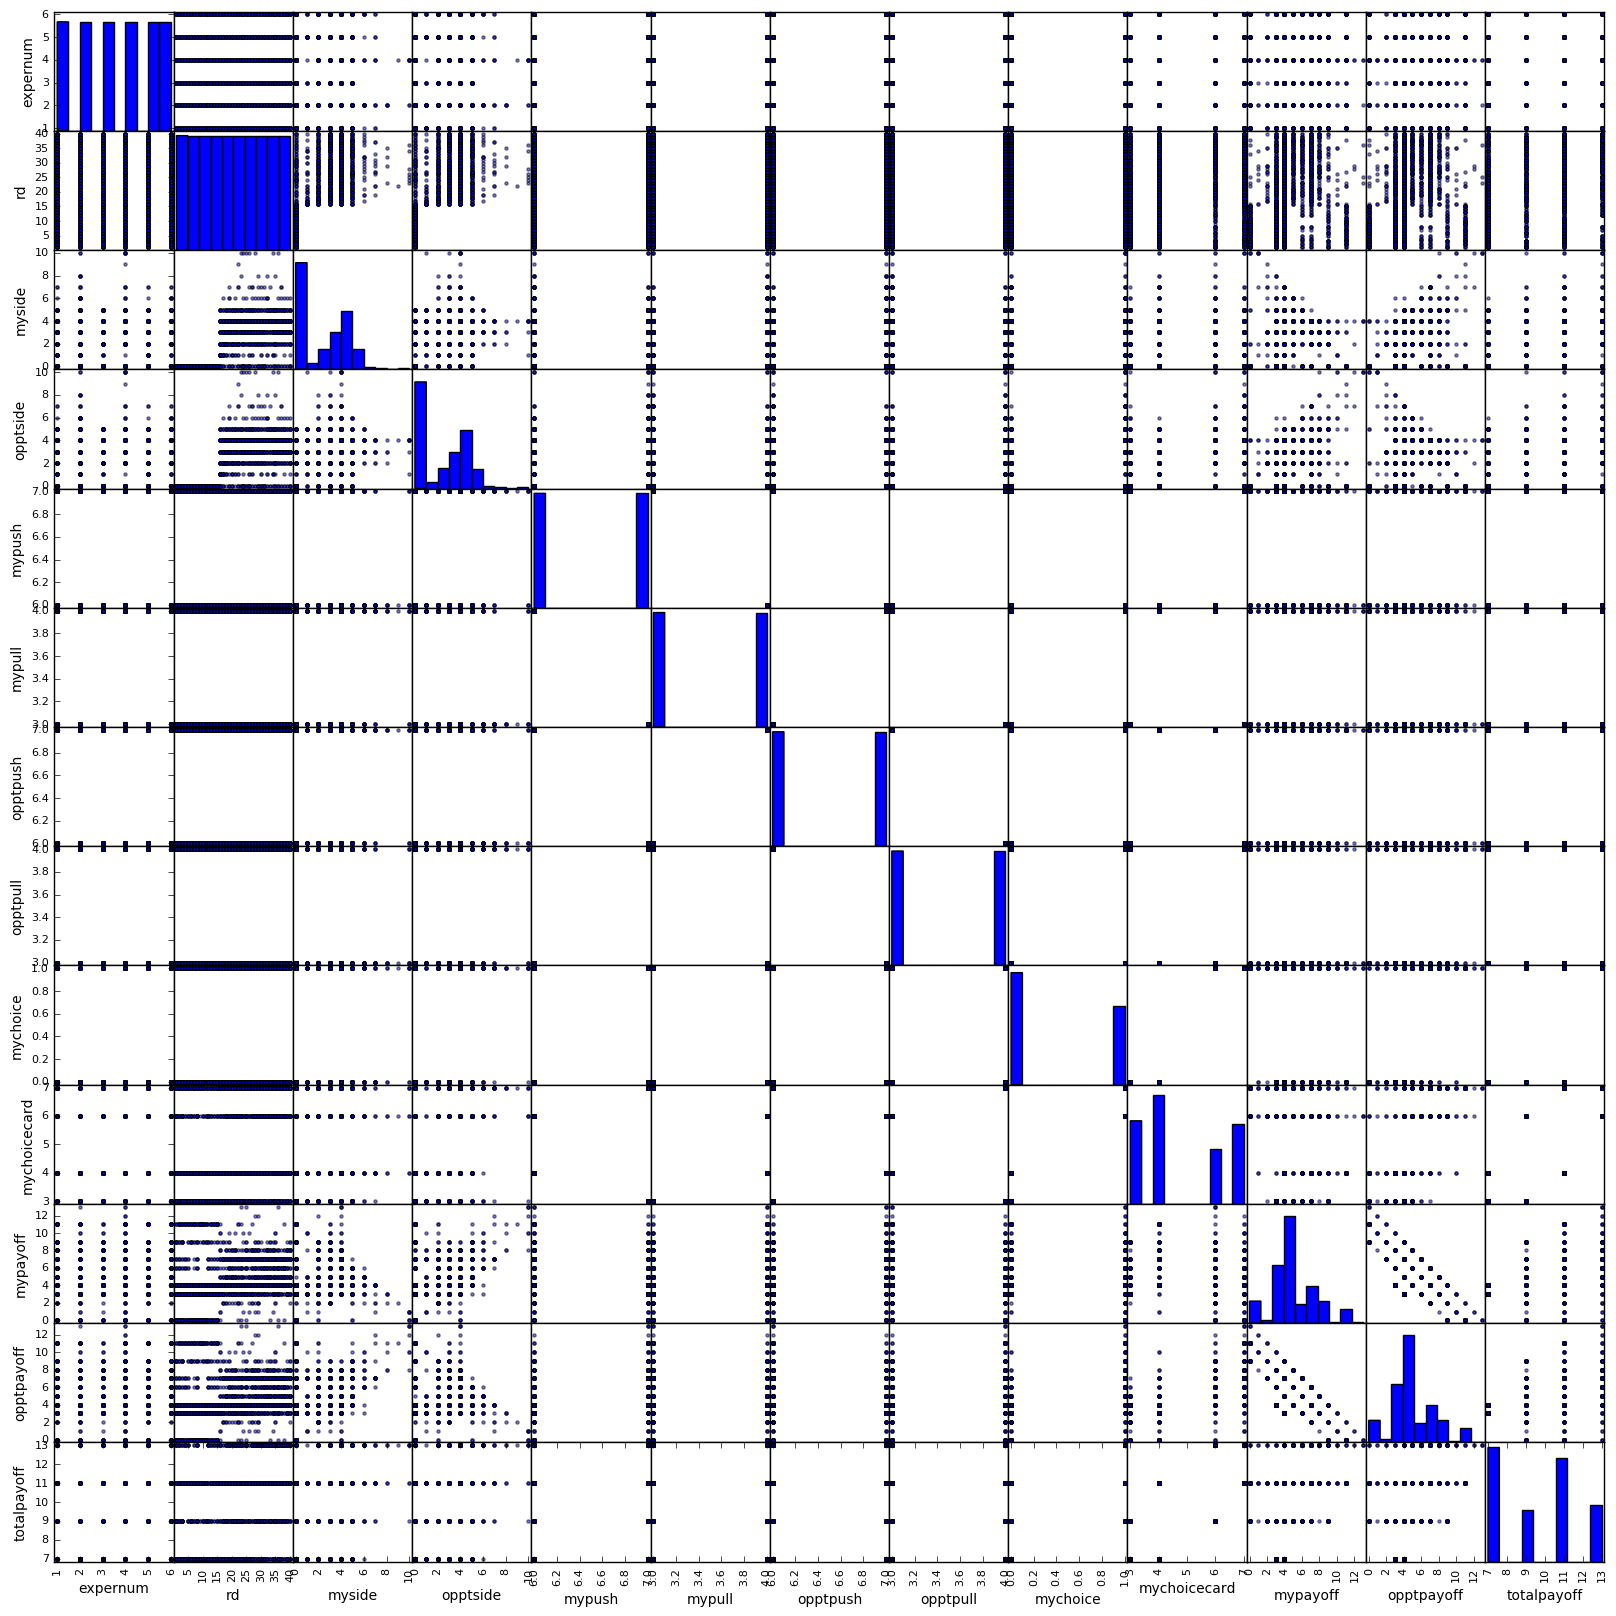

In [272]:
pd.scatter_matrix(ultimatum_df,figsize=(20,20));

- There seems to be some a relationship between the side payments and the payoffs between players.

### The first 15 rounds did not involve a side payment (paying the other person to accept your proposal), we will analyze this group first.

In [273]:
ultimatum_rd15_df = ultimatum_df[(ultimatum_df.rd <=15)]

ultimatum_pastrd15_df = ultimatum_df[(ultimatum_df.rd >15)]

In [274]:
ultimatum_rd15_df.head()

,expernum,rd,myside,opptside,mypush,mypull,opptpush,opptpull,mychoice,mychoicecard,mypayoff,opptpayoff,totalpayoff
0,1,1,0,0,6,4,7,3,0,4,11,0,11
1,1,1,0,0,7,3,6,4,1,7,0,11,11
2,1,1,0,0,6,4,7,3,0,4,4,3,7
3,1,1,0,0,7,3,6,4,0,3,3,4,7
4,1,1,0,0,7,3,6,4,1,7,6,7,13


In [275]:
ultimatum_rd15_df.describe()

,expernum,rd,myside,opptside,mypush,mypull,opptpush,opptpull,mychoice,mychoicecard,mypayoff,opptpayoff,totalpayoff
count,720.000000,720.000000,720.0,720.0,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,3.500000,8.000000,0.0,0.0,6.500000,3.500000,6.500000,3.500000,0.258333,4.341667,4.341667,4.341667,8.683333
std,1.709012,4.323497,0.0,0.0,0.500348,0.500348,0.500348,0.500348,0.438022,1.438566,3.363047,3.363047,2.072336
min,1.000000,1.000000,0.0,0.0,6.000000,3.000000,6.000000,3.000000,0.000000,3.000000,0.000000,0.000000,7.000000
25%,2.000000,4.000000,0.0,0.0,6.000000,3.000000,6.000000,3.000000,0.000000,3.000000,3.000000,3.000000,7.000000
50%,3.500000,8.000000,0.0,0.0,6.500000,3.500000,6.500000,3.500000,0.000000,4.000000,4.000000,4.000000,7.000000
75%,5.000000,12.000000,0.0,0.0,7.000000,4.000000,7.000000,4.000000,1.000000,6.000000,6.000000,6.000000,11.000000
max,6.000000,15.000000,0.0,0.0,7.000000,4.000000,7.000000,4.000000,1.000000,7.000000,11.000000,11.000000,13.000000


- Now drop, expernum

In [276]:
ultimatum_rd15_df = ultimatum_rd15_df.iloc[:,1:]
ultimatum_pastrd15_df = ultimatum_pastrd15_df.iloc[:,1:]

In [277]:
ultimatum_rd15_df.head()

,rd,myside,opptside,mypush,mypull,opptpush,opptpull,mychoice,mychoicecard,mypayoff,opptpayoff,totalpayoff
0,1,0,0,6,4,7,3,0,4,11,0,11
1,1,0,0,7,3,6,4,1,7,0,11,11
2,1,0,0,6,4,7,3,0,4,4,3,7
3,1,0,0,7,3,6,4,0,3,3,4,7
4,1,0,0,7,3,6,4,1,7,6,7,13


In [278]:
ultimatum_rd15_df.columns

Index(['rd', 'myside', 'opptside', 'mypush', 'mypull', 'opptpush', 'opptpull',
       'mychoice', 'mychoicecard', 'mypayoff', 'opptpayoff', 'totalpayoff'],
      dtype='object')

## Within each group, there are two outcomes to test
    - 1) Maximize your own payoff
    - 2) Maximize total payoff

In [279]:
#Group one-maximize your payoff
ultimatum_rd15_df_mypayoff_X = np.array(ultimatum_rd15_df.iloc[:,:9])
ultimatum_rd15_df_mypayoff_y = np.array(ultimatum_rd15_df.iloc[:,9])
ultimatum_pastrd15_df_mypayoff_X = np.array(ultimatum_pastrd15_df.iloc[:,:9])
ultimatum_pastrd15_df_mypayoff_y = np.array(ultimatum_pastrd15_df.iloc[:,9])
### get the labels associated with each columns
ultimatum_rd15_df_mypayoff_Xlabels = np.array(['rd', 'myside', 'opptside', 'mypush', 'mypull', 'opptpush', 'opptpull',
       'mychoice', 'mychoicecard'])
ultimatum_rd15_df_mypayoff_ylabels = ['mypayoff']
ultimatum_rd15_df_totalpayoff_Xlabels = np.array(['rd','myside', 'opptside', 'mypush', 'mypull', 'opptpush', 'opptpull',
       'mychoice','mychoicecard'])
ultimatum_rd15_df_totalpayoff_ylabels = ['totalpayoff']

#Group two-maximize total payoff
ultimatum_rd15_df_totalpayoff_X =  np.array(ultimatum_rd15_df.iloc[:,:9])
ultimatum_rd15_df_totalpayoff_y = np.array(ultimatum_rd15_df.iloc[:,11])
ultimatum_pastrd15_df_totalpayoff_X =  np.array(ultimatum_pastrd15_df.iloc[:,:9])
ultimatum_pastrd15_df_totalpayoff_y = np.array(ultimatum_pastrd15_df.iloc[:,11])
### get the labels associated with each columns
ultimatum_pastrd15_df_mypayoff_Xlabels = np.array(['rd','myside', 'opptside', 'mypush', 'mypull', 'opptpush', 'opptpull',
        'mychoice','mychoicecard'])
ultimatum_pastrd15_df_mypayoff_ylabels = ['mypayoff']
ultimatum_pastrd15_df_totalpayoff_Xlabels = np.array(['rd','myside', 'opptside', 'mypush', 'mypull', 'opptpush', 'opptpull',
    'mychoice','mychoicecard'])
ultimatum_pastrd15_df_totalpayoff_ylabels = ['totalpayoff']

## Random Forest to predict your payoff for the first 15 rounds

In [107]:
#How much data do we have?
np.shape(ultimatum_rd15_df_mypayoff_X )

(720, 9)

In [108]:
#Not that much data...something to be aware of

In [160]:
regression_model_15_mypayoff= Model_Testing_Regression(ultimatum_rd15_df_mypayoff_X ,ultimatum_rd15_df_mypayoff_y,3,ultimatum_rd15_df_mypayoff_Xlabels,ultimatum_rd15_df_mypayoff_ylabels )

In [161]:
#default
regression_model_15_mypayoff.random_forest(100,'auto',None)

('RMSE Val:',
 2.8968245039402407,
 'RMSE Train:',
 2.6778324134454539,
 'RMSE TEST:',
 3.1453241074213203,
 [('rd', 0.31045210967923054),
  ('mychoicecard', 0.31008902100445018),
  ('mychoice', 0.20153460698195982),
  ('opptpush', 0.053434247087892538),
  ('mypull', 0.042903977119836269),
  ('opptpull', 0.04137114068468483),
  ('mypush', 0.040214897441945875),
  ('opptside', 0.0),
  ('myside', 0.0)])

- Plot out the progression of RF as we add more trees.

In [111]:
txt_v_rf,rmse_val_rf,txt_tr_rf,rmse_train_rf,txt_test_rf,rmse_test_rf,features_rf= zip(*[regression_model_15_mypayoff.random_forest(i,'auto',None) for i in range(1,700,25)])

Min RMSE for validation set: 2.893476306659861, 3 folds cv
Min RMSE for train set: 2.6599493553687434, 3 folds cs
Min RMSE for test set: 2.891060423054503, 3 folds cv


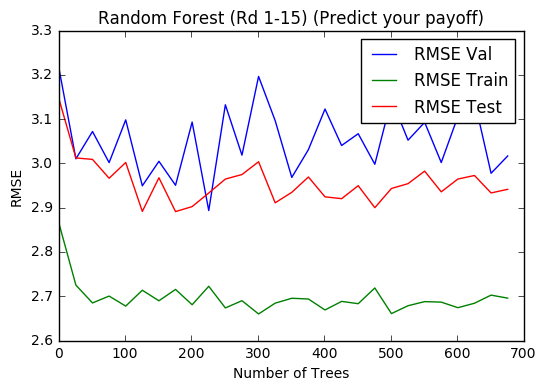

In [112]:
plt.plot([i for i in range(1,700,25)], rmse_val_rf,label='RMSE Val')
plt.plot([i for i in range(1,700,25)],rmse_train_rf , label='RMSE Train')
plt.plot([i for i in range(1,700,25)],rmse_test_rf, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_rf),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_rf),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_rf),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Random Forest (Rd 1-15) (Predict your payoff)')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE');

- Min cv test error at ~2.86 (units are dollars). Best parameters from min validation error of ~2.92 at ~600 tree

# Final model below - Random Forest - Predict your payoff

In [23]:

regression_model_15_mypayoff.random_forest(600,'auto',None)

('RMSE Val:',
 3.1434235182854393,
 'RMSE Train:',
 2.6311618432596835,
 'RMSE TEST:',
 3.0748310758515895,
 [('rd', 0.32935817268409862),
  ('mychoicecard', 0.26976884269170015),
  ('mychoice', 0.20663855063495215),
  ('mypush', 0.052337512372414373),
  ('mypull', 0.048434985437210608),
  ('opptpull', 0.047278818402119199),
  ('opptpush', 0.046183117777504633),
  ('opptside', 0.0),
  ('myside', 0.0)])

- It is interesting that round number is the most important feature. This means that as people learn how to play the game, the ability to predict your payoff increases.
- In addition, the number on your choice card is the second most important feature. This makes sense, the choice to push or pull is very important.

## Gradient Boosting to maximize your payoff rounds 1-15

In [24]:
#start with deafult
regression_model_15_mypayoff.gradient_boost(loss_type='ls',learning_rate_n=1.0,n_estimators_n=100,max_depth_n=3)

('RMSE Val:',
 3.1243672249400301,
 'RMSE Train:',
 2.637826694659156,
 'RMSE TEST:',
 3.1412316347840616,
 [('rd', 0.63980800131136562),
  ('mychoicecard', 0.19060337063638447),
  ('mychoice', 0.093323231804836704),
  ('opptpush', 0.024980967964566742),
  ('mypush', 0.020621118870314228),
  ('mypull', 0.020075204134110892),
  ('opptpull', 0.01058810527842143),
  ('opptside', 0.0),
  ('myside', 0.0)])

In [25]:
txt_v_gb,rmse_val_gb,txt_tr_gb,rmse_train_gb,txt_test_gb,rmse_test_gb,features_gb=\
zip(*[regression_model_15_mypayoff.gradient_boost(loss_type='ls',learning_rate_n=1.0,n_estimators_n=i,max_depth_n=1)\
      for i in range(1,1000,25)])

Min RMSE for validation set: 2.8042553761930367, 3 folds cv
Min RMSE for train set: 2.761841457625058, 3 folds cs
Min RMSE for test set: 2.904791497701515, 3 folds cv


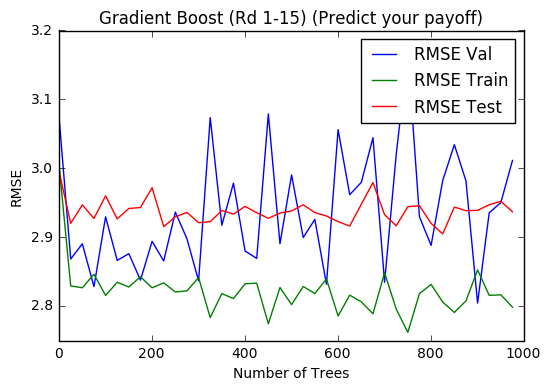

In [26]:
#plot the current model
plt.plot([i for i in range(1,1000,25)], rmse_val_gb,label='RMSE Val')
plt.plot([i for i in range(1,1000,25)],rmse_train_gb, label='RMSE Train')
plt.plot([i for i in range(1,1000,25)],rmse_test_gb, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_gb),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Gradient Boost (Rd 1-15) (Predict your payoff)')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE');

- Min test RMSE of ~2.82 around with best parameters coming from the min validation error of ~2.8 at 700 trees for the training data. Next, repeat this with huber loss. 

In [27]:
txt_v_gb,rmse_val_gb,txt_tr_gb,rmse_train_gb,txt_test_gb,rmse_test_gb,features_gb=\
zip(*[regression_model_15_mypayoff.gradient_boost(loss_type='huber',learning_rate_n=1.0,n_estimators_n=i,max_depth_n=1)\
      for i in range(1,1000,25)])

Min RMSE for validation set: 2.736212970031808, 3 folds cv
Min RMSE for train set: 2.812824219198204, 3 folds cs
Min RMSE for test set: 2.907316300454241, 3 folds cv


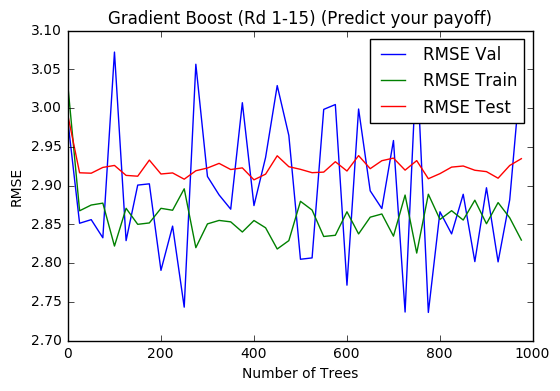

In [28]:
#plot the current model
plt.plot([i for i in range(1,1000,25)], rmse_val_gb,label='RMSE Val')
plt.plot([i for i in range(1,1000,25)],rmse_train_gb, label='RMSE Train')
plt.plot([i for i in range(1,1000,25)],rmse_test_gb, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_gb),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Gradient Boost (Rd 1-15) (Predict your payoff)')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE');

- Min cv test RMSE about the same at ~2.84 for test. Best parameters from cv validation RMSE comes from 225 tress and huber loss.Next, attempt to optimize the learning rate with 225 trees and huber loss.

In [29]:
txt_v_gb,rmse_val_gb,txt_tr_gb,rmse_train_gb,txt_test_gb,rmse_test_gb,features_gb=\
zip(*[regression_model_15_mypayoff.gradient_boost(loss_type='huber',learning_rate_n=i,n_estimators_n=225,max_depth_n=1)\
      for i in np.linspace(.00001,2,20)])

Min RMSE for validation set: 2.6956369551711483, 3 folds cv
Min RMSE for train set: 2.792432007552343, 3 folds cs
Min RMSE for test set: 2.9138252877906936, 3 folds cv


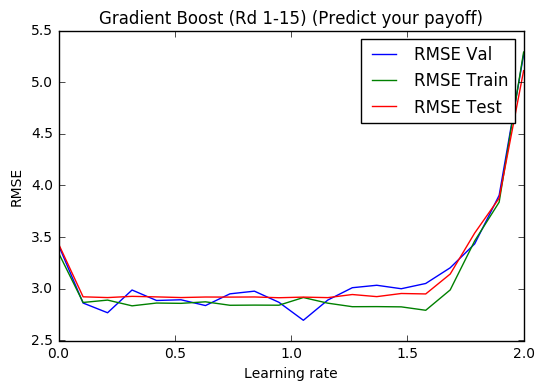

In [30]:
#plot the current model
plt.plot([i for i in np.linspace(.00001,2,20)], rmse_val_gb,label='RMSE Val')
plt.plot([i for i in np.linspace(.00001,2,20)],rmse_train_gb, label='RMSE Train')
plt.plot([i for i in np.linspace(.00001,2,20)],rmse_test_gb, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_gb),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Gradient Boost (Rd 1-15) (Predict your payoff)')
plt.xlabel('Learning rate')
plt.ylabel('RMSE');

- Min cv test RMSE about the same at ~2.85 for training data. Best parameter for learning rate from cv validation RMSE at .9 for validation set. Next, max_depth with learning rate .9, 225 trees, and huber loss.

In [34]:
txt_v_gb,rmse_val_gb,txt_tr_gb,rmse_train_gb,txt_test_gb,rmse_test_gb,features_gb=\
zip(*[regression_model_15_mypayoff.gradient_boost(loss_type='huber',learning_rate_n=.9,n_estimators_n=225,max_depth_n=i)\
      for i in range(1,10)])

Min RMSE for validation set: 2.833561768525618, 3 folds cv
Min RMSE for train set: 2.6696186701425906, 3 folds cs
Min RMSE for test set: 2.915256075397694, 3 folds cv


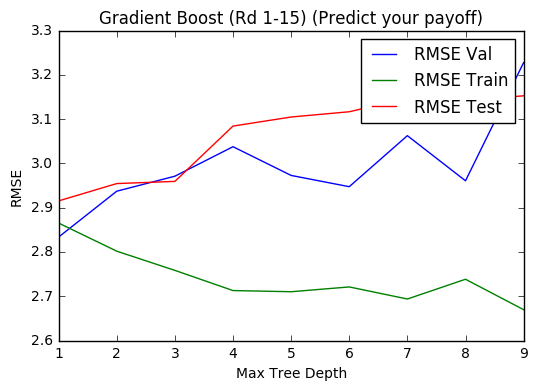

In [32]:
#plot the current model
plt.plot([i for i in range(1,10)], rmse_val_gb,label='RMSE Val')
plt.plot([i for i in range(1,10)],rmse_train_gb, label='RMSE Train')
plt.plot([i for i in range(1,10)],rmse_test_gb, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_gb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_gb),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Gradient Boost (Rd 1-15) (Predict your payoff)')
plt.xlabel('Max Tree Depth')
plt.ylabel('RMSE');

- Slightly lower min cv RMSE for training data of 2.67~. Best parameters from cv validation with max depth=6.
- Build a final model with the parameters estimated from above.

### Final Model - Gradient Boosting - Predict your payoff


In [35]:
#Best parameters
regression_model_15_mypayoff.gradient_boost(loss_type='huber',learning_rate_n=.9,n_estimators_n=225,max_depth_n=6)

('RMSE Val:',
 3.147606486373423,
 'RMSE Train:',
 2.6774991732133455,
 'RMSE TEST:',
 3.1219329967907758,
 [('rd', 0.54939598253031019),
  ('mypush', 0.11904384083643056),
  ('opptpull', 0.10802029645470478),
  ('mychoicecard', 0.076418352934813583),
  ('mychoice', 0.051859534258513029),
  ('opptpush', 0.048392388165881199),
  ('mypull', 0.046869604819346634),
  ('opptside', 0.0),
  ('myside', 0.0)])

- Min RMSE on test data for Gradient boosting ~3.12 vs min RMSE on test data for Random Forest of ~3.11. About the same.
- In comparison to the Random Forest model, the gradient boosted model highlights that rd is overall the most important feature (~5x more important that my push).
- In contrast, Random Forest ranked rd 1.5x more importance than my choice card. My push card (the second highest ranked feature from gradient boost), was the fourth most important feature from Random Forest.

# Test Extreme Gradient Boosting to maximizing your payoff for the first 15 rounds.

In [57]:
#Start with default parameters
regression_model_15_mypayoff.extreme_gradient_boost()

('RMSE Val:',
 2.8523358888468242,
 'RMSE Train:',
 2.7109310629213095,
 'RMSE TEST:',
 3.0344832489001203,
 [('rd', 0.62402946),
  ('mypush', 0.15319245),
  ('mychoice', 0.14905412),
  ('mychoicecard', 0.07372392),
  ('opptpull', 0.0),
  ('opptpush', 0.0),
  ('mypull', 0.0),
  ('opptside', 0.0),
  ('myside', 0.0)])

- First, start with n_estimators to optimize

In [61]:
txt_v_xgb,rmse_val_xgb,txt_tr_xgb,rmse_train_xgb,txt_test_xgb,rmse_test_xgb,features_xgb=\
zip(*[regression_model_15_mypayoff.extreme_gradient_boost(n_estimators_n=i) for i in range(1,500,25)])

Min RMSE for validation set: 2.8557129864484163, 3 folds cv
Min RMSE for train set: 2.62044359473903, 3 folds cs
Min RMSE for test set: 2.9727815906890043, 3 folds cv


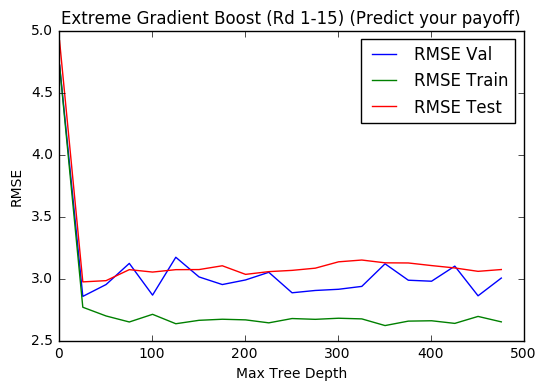

In [63]:
#plot the current model
plt.plot([i for i in range(1,500,25)], rmse_val_xgb,label='RMSE Val')
plt.plot([i for i in range(1,500,25)],rmse_train_xgb, label='RMSE Train')
plt.plot([i for i in range(1,500,25)],rmse_test_xgb, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_xgb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_xgb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_xgb),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Extreme Gradient Boost (Rd 1-15) (Predict your payoff)')
plt.xlabel('Max Tree Depth')
plt.ylabel('RMSE');

- Min validation RMSE at 250 trees. Next, optimize the max depth.

In [64]:
txt_v_xgb,rmse_val_xgb,txt_tr_xgb,rmse_train_xgb,txt_test_xgb,rmse_test_xgb,features_xgb=\
zip(*[regression_model_15_mypayoff.extreme_gradient_boost(n_estimators_n=250,max_depth_n=i) for i in range(1,50,2)])

Min RMSE for validation set: 2.8513328463345466, 3 folds cv
Min RMSE for train set: 2.585411349518353, 3 folds cs
Min RMSE for test set: 2.940506905043248, 3 folds cv


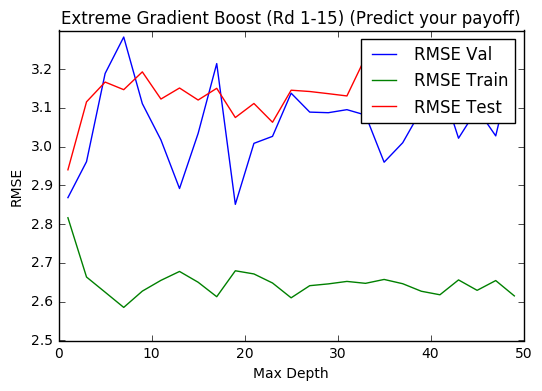

In [65]:
#plot the current model
plt.plot([i for i in range(1,50,2)], rmse_val_xgb,label='RMSE Val')
plt.plot([i for i in range(1,50,2)],rmse_train_xgb, label='RMSE Train')
plt.plot([i for i in range(1,50,2)],rmse_test_xgb, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_xgb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_xgb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_xgb),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Extreme Gradient Boost (Rd 1-15) (Predict your payoff)')
plt.xlabel('Max Depth')
plt.ylabel('RMSE');

- Max depth at 12 trees for validation set. Next, optimize the learning rate.

In [72]:
txt_v_xgb,rmse_val_xgb,txt_tr_xgb,rmse_train_xgb,txt_test_xgb,rmse_test_xgb,features_xgb=\
zip(*[regression_model_15_mypayoff.extreme_gradient_boost(n_estimators_n=250,max_depth_n=12,learning_rate_n=i) for i in np.linspace(.01,2.0,20)])

Min RMSE for validation set: 2.9157689264796893, 3 folds cv
Min RMSE for train set: 2.6110810220522485, 3 folds cs
Min RMSE for test set: 3.0689063878872513, 3 folds cv


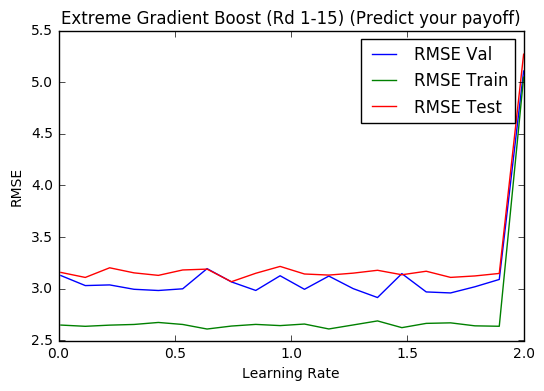

In [74]:
#plot the current model
plt.plot([i for i in np.linspace(.01,2.0,20)], rmse_val_xgb,label='RMSE Val')
plt.plot([i for i in np.linspace(.01,2.0,20)],rmse_train_xgb, label='RMSE Train')
plt.plot([i for i in np.linspace(.01,2.0,20)],rmse_test_xgb, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_xgb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_xgb),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_xgb),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Extreme Gradient Boost (Rd 1-15) (Predict your payoff)')
plt.xlabel('Learning Rate')
plt.ylabel('RMSE');

- Min validation error at learning rate of ~.5. Final model presented below.

#### Final Model - Extreme Gradient Boosting - Predict your payoff (rd1-15)

In [80]:
regression_model_15_mypayoff.extreme_gradient_boost(n_estimators_n=250,max_depth_n=12,learning_rate_n=.5)

('RMSE Val:',
 3.1915629211168142,
 'RMSE Train:',
 2.6091351856397695,
 'RMSE TEST:',
 3.1649737824435533,
 [('rd', 0.90768051),
  ('mypush', 0.065586373),
  ('mychoice', 0.025062295),
  ('mychoicecard', 0.0016708198),
  ('opptpull', 0.0),
  ('opptpush', 0.0),
  ('mypull', 0.0),
  ('opptside', 0.0),
  ('myside', 0.0)])

# GLMnet - Maximize your payoff - Rd 1-15
- Normalize the data. Note, the coefficients can only now be used to rank the importance, not to interpret what each coefficient means.

In [283]:
## scale the data
scale = StandardScaler()
ultimatum_rd15_df_mypayoff_X_scaled =scale.fit_transform(ultimatum_rd15_df_mypayoff_X)


/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [289]:
## look at a row
ultimatum_rd15_df_mypayoff_X_scaled[0]

array([-1.62018517,  0.        ,  0.        , -1.        ,  1.        ,
        1.        , -1.        , -0.59018184, -0.23767018])

In [290]:
regression_model_15_mypayoff_scaled= Model_Testing_Regression(ultimatum_rd15_df_mypayoff_X_scaled,\
                                ultimatum_rd15_df_mypayoff_y,3,ultimatum_rd15_df_mypayoff_Xlabels,ultimatum_rd15_df_mypayoff_ylabels)

In [291]:
### Default model
regression_model_15_mypayoff_scaled.glm_net()

('RMSE Val:',
 3.2024014284447038,
 'RMSE Train:',
 3.0136936412102018,
 'RMSE TEST:',
 2.8157824205561308,
 [('mychoice', 0.51001813643061666),
  ('mypush', 0.12834100948476146),
  ('mypull', 0.12832747556431109),
  ('opptpush', 0.12825085201258024),
  ('opptpull', 0.1282477447603623),
  ('mychoicecard', 0.10773856401941573),
  ('opptside', 0.0),
  ('myside', 0.0),
  ('rd', 0.0)])

- First, optimize the alpha or learning rate.

In [303]:
txt_v_en,rmse_val_en,txt_tr_en,rmse_train_en,txt_test_en,rmse_test_en,features_en=\
zip(*[regression_model_15_mypayoff_scaled.glm_net(alpha_n=i) for i in np.linspace(.01,.2,50)])

Min RMSE for validation set: 2.798625020211317, 3 folds cv
Min RMSE for train set: 2.8572356760993842, 3 folds cs
Min RMSE for test set: 2.6598789226792032, 3 folds cv


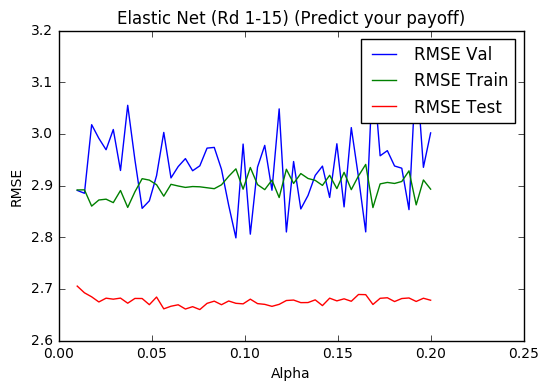

In [304]:
#plot the current model
plt.plot([i for i in np.linspace(.01,.2,50)], rmse_val_en,label='RMSE Val')
plt.plot([i for i in np.linspace(.01,.2,50)],rmse_train_en, label='RMSE Train')
plt.plot([i for i in np.linspace(.01,.2,50)],rmse_test_en, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_en),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_en),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_en),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Elastic Net (Rd 1-15) (Predict your payoff)')
plt.xlabel('Alpha')
plt.ylabel('RMSE');

- search for smaller alpha

In [305]:
txt_v_en,rmse_val_en,txt_tr_en,rmse_train_en,txt_test_en,rmse_test_en,features_en=\
zip(*[regression_model_15_mypayoff.glm_net(alpha_n=i) for i in np.linspace(.01,.2,50)])

Min RMSE for validation set: 2.684478735520211, 3 folds cv
Min RMSE for train set: 2.8161155640244107, 3 folds cs
Min RMSE for test set: 2.9447600293917127, 3 folds cv


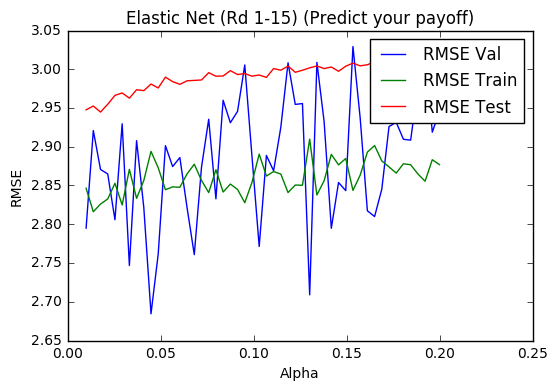

In [306]:
#plot the current model
plt.plot([i for i in np.linspace(.01,.2,50)], rmse_val_en,label='RMSE Val')
plt.plot([i for i in np.linspace(.01,.2,50)],rmse_train_en, label='RMSE Train')
plt.plot([i for i in np.linspace(.01,.2,50)],rmse_test_en, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_en),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_en),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_en),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Elastic Net (Rd 1-15) (Predict your payoff)')
plt.xlabel('Alpha')
plt.ylabel('RMSE');

- Min validation cv at alpha of ~.04. Next, optimize lambda. The ratio between l1 and l2 penalty.

In [307]:
txt_v_en,rmse_val_en,txt_tr_en,rmse_train_en,txt_test_en,rmse_test_en,features_en=\
zip(*[regression_model_15_mypayoff_scaled.glm_net(alpha_n=.04,l1_ratio_n=i) for i in np.linspace(.001,.99,50)])

Min RMSE for validation set: 2.739577926729359, 3 folds cv
Min RMSE for train set: 2.854211729995215, 3 folds cs
Min RMSE for test set: 2.664868357839205, 3 folds cv


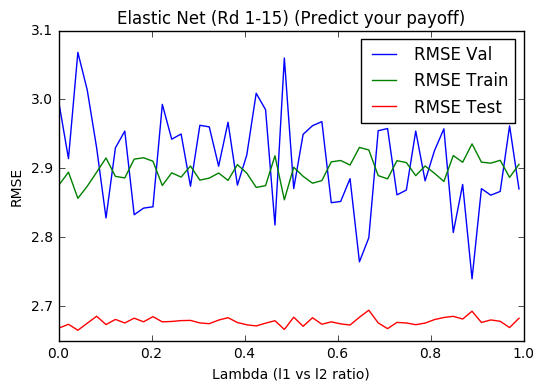

In [308]:
#plot the current model
plt.plot([i for i in np.linspace(.001,.99,50)], rmse_val_en,label='RMSE Val')
plt.plot([i for i in np.linspace(.001,.99,50)],rmse_train_en, label='RMSE Train')
plt.plot([i for i in np.linspace(.001,.99,50)],rmse_test_en, label = 'RMSE Test')
print('Min RMSE for validation set: {}, {} folds cv'.format(min(rmse_val_en),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for train set: {}, {} folds cs'.format(min(rmse_train_en),regression_model_15_mypayoff.number_of_folds))
print('Min RMSE for test set: {}, {} folds cv'.format(min(rmse_test_en),regression_model_15_mypayoff.number_of_folds))
plt.legend()
plt.title('Elastic Net (Rd 1-15) (Predict your payoff)')
plt.xlabel('Lambda (l1 vs l2 ratio)')
plt.ylabel('RMSE');

- Optimal lambda at ~.9. Print the final model.

### Final Model - Elastic net - Predict your payoff - Rd 1-15

In [310]:
regression_model_15_mypayoff.glm_net(alpha_n=.04,l1_ratio_n=.9)

('RMSE Val:',
 2.8170219120552615,
 'RMSE Train:',
 2.8506333923034108,
 'RMSE TEST:',
 2.9603078164588035,
 [('mychoice', 2.013513941111257),
  ('opptpull', 0.51509399504272446),
  ('opptpush', 0.50706204778236386),
  ('mypush', 0.5028758995608944),
  ('mypull', 0.49465646916094813),
  ('mychoicecard', 0.27855068439677466),
  ('rd', 0.024423010429754016),
  ('opptside', 0.0),
  ('myside', 0.0)])

- Elastic net has a better test RMSE than RF, Gradient Boosting, and Extreme gradient boosting.
- It is interesting to note that the feature importances are ranked very differently in this regression model compared to the tree model (my choice card is the most important feature here). 
- About the same RMSE for the test set as the other two models (Gradient Boosting and Random Forest). The top two most important features are ranked the same way between these two models.

# Find the best features using randomized grid search (compare to manual grid search above).

In [312]:
random_forest_parameters = {'n_estimators':[i for i in range(1,500)],'max_depth':[i for i in range(1,500)],\
                            'min_samples_split':[i for i in range(2,50)],\
                            'min_samples_leaf':[i for i in range(1,50)],\
                            'max_features':['auto','sqrt','log2'],\
                            'max_leaf_nodes':[i for i in range(2,500,1)]}

In [313]:
extreme_gradient_boost_parameters = {'max_depth':[i for i in range(1,50)], 'learning_rate':[i for i in np.linspace(.001,.9,50)],
                                     'n_estimators':[i for i in range(50,1000,10)],
                                     'reg_alpha':[i for i in np.linspace(.001,5.0,50)],
                                     'reg_lambda':[i for i in np.linspace(.001,5.0,50)]
}

In [314]:
gradient_boost_parameters = {'loss':['ls', 'lad', 'huber', 'quantile'], 'learning_rate':[i for i in np.linspace(.001,.9,50)],\
                            'n_estimators':[i for i in range(50,500,10)], 'criterion':['friedman_mse'],\
                            'min_samples_split':[i for i in range(2,20)], 'min_samples_leaf':[i for i in range(1,20)],\
                            'max_depth':[i for i in range(1,50)],'subsample':[i for i in np.linspace(.001,1,30)],\
                              'alpha':[i for i in np.linspace(.001,.99,30)],'max_features':['auto','sqrt','log2']}

In [311]:
glm_net_parameters = {'alpha':[i for i in np.linspace(.001,.99,30)],'l1_ratio':[i for i in np.linspace(.001,5.0,100)]  
}



In [ ]:
ElasticNet()

# Predictions - Maximize your payoff - Rd 1-15

In [162]:
###Columns needed
regression_model_15_mypayoff.x_labels

array(['rd', 'myside', 'opptside', 'mypush', 'mypull', 'opptpush',
       'opptpull', 'mychoice', 'mychoicecard'], 
      dtype='<U12')

In [114]:
#Random Forest
predict_rf = RandomForestRegressor(n_estimators=600,max_features='auto',max_depth=None)

In [115]:
predict_rf.fit(regression_model_15_mypayoff.X_trainval,regression_model_15_mypayoff.y_trainval)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [127]:
### predictions
## my choice = 1 = pull
#['rd', 'myside', 'opptside', 'mypush', 'mypull', 'opptpush' 'opptpull', 'mychoice', 'mychoicecard'],
prediction = [predict_rf.predict(np.array([i,0,0,6,4,7,3,1,6]).reshape(1,-1)) for i in range(1,15)]

In [131]:
print('Pull payoffs - RF')
prediction

Pull payoffs - RF


[array([ 2.53254141]),
 array([ 4.18521484]),
 array([ 1.79088218]),
 array([ 6.80708188]),
 array([ 3.55637668]),
 array([ 0.03540404]),
 array([ 2.3000463]),
 array([ 2.22322354]),
 array([ 1.36220833]),
 array([ 0.00777778]),
 array([ 0.00583333]),
 array([ 3.60748527]),
 array([ 3.50387963]),
 array([ 4.73631481])]

# Maximize your payoff incorporating a side payment (RDs 15+)

In [86]:
np.shape(ultimatum_pastrd15_df_mypayoff_X)

(1200, 9)

In [90]:
### Almost twice the amount of data compared to the first 15 rounds.

In [82]:
regression_model_past15_mypayoff = Model_Testing_Regression(ultimatum_pastrd15_df_mypayoff_X,\
                                                            ultimatum_pastrd15_df_mypayoff_y,3,\
                                                           ultimatum_rd15_df_totalpayoff_Xlabels ,\
                                                           ultimatum_rd15_df_totalpayoff_ylabels)

In [85]:
regression_model_past15_mypayoff.random_forest()

('RMSE Val:',
 1.5526785287123166,
 'RMSE Train:',
 0.78930343588958174,
 'RMSE TEST:',
 1.4474960066208664,
 [('opptside', 0.30223989531451595),
  ('rd', 0.24544905851796894),
  ('myside', 0.23525570392652162),
  ('opptpush', 0.049599777379019556),
  ('mypull', 0.043318721279968088),
  ('mychoice', 0.035589693168690463),
  ('opptpull', 0.031115040602001858),
  ('mychoicecard', 0.029791366932721133),
  ('mypush', 0.027640742878592361)])

In [84]:
%autoreload 2

# Testing

In [402]:
k = xgboost()

TypeError: 'module' object is not callable

In [356]:
k.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [357]:
k.feature_importances_

array([ 0.19572713,  0.22381183,  0.00851486,  0.00564032,  0.00607822,
        0.00593937,  0.08559879,  0.0914844 ,  0.17868483,  0.19852025])

In [358]:
k.get_params

<bound method BaseEstimator.get_params of GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)>

In [ ]:
k.

In [118]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [229]:
%autoreload 2

In [148]:
k = RandomForestRegressor()

In [41]:
X_train, X_val, y_train, y_val = train_test_split(ultimatum_pastrd15_df_mypayoff_X,ultimatum_pastrd15_df_mypayoff_y,test_size=.2)

In [161]:
k.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [162]:
k.predict(X_val)

array([  4. ,   3. ,   7. ,   4. ,   3. ,   4. ,   4. ,   7. ,   4. ,
         4. ,   4. ,   3. ,   7. ,   3. ,   7. ,   4. ,   6. ,   4. ,
         3. ,   7. ,   8. ,   4. ,   0.1,   4. ,   5. ,   3. ,   6. ,
         3. ,   2.5,   3. ,   5. ,   6. ,   3. ,   4. ,   7. ,   8. ,
         7. ,   3. ,   7. ,   7. ,   4. ,   3. ,   4. ,   7. ,   8. ,
         7. ,   8. ,   5. ,   7. ,   7. ,   7. ,   7. ,   7. ,   3.6,
         3. ,   0.8,   1.9,   7.1,   5. ,   6. ,   8. ,   4. ,   3. ,
         5. ,   7. ,   7. ,   4. ,   4. ,   3. ,   3. ,   5. ,   7. ,
         5. ,   4. ,   3. ,   3. ,   7. ,   3. ,   5.9,   7.4,   4. ,
         5. ,   3. ,   4. ,   4. ,   5. ,   5.9,   5. ,   7. ,   4. ,
         7. ,   4. ,   3. ,   7. ,   4. ,   4. ,   4. ,   3. ,   4. ,
         4. ,   6. ,   7. ,   3. ,   3. ,   5. ,   4. ,   3. ,   5. ,
         4. ,   3. ,   6. ,   7. ,   6. ,   3. ,   3. ,   3. ,   4.2,
         5.9,   5. ,   4. ,   2. ,   7. ,   4. ,   9. ,   9.4,   4. ,
         9.8,   3. ,

In [164]:
k.feature_importances_

array([ 0.24584297,  0.18873703,  0.00509507,  0.00442744,  0.00791902,
        0.01016818,  0.01719171,  0.25755302,  0.03104099,  0.23202458])

In [267]:
model_class = model_testing_regression(ultimatum_rd15_df_mypayoff_X ,ultimatum_rd15_df_mypayoff_y,3,ultimatum_rd15_df_mypayoff_Xlabels,ultimatum_rd15_df_mypayoff_ylabels )

In [268]:
ultimatum_rd15_df_mypayoff_Xlabels

array(['rd', 'myside', 'opptside', 'mypush', 'mypull', 'opptpush',
       'opptpull', 'mychoicecard', 'opptchoicecard'], 
      dtype='<U14')

In [270]:
model_class.random_forest(5,'auto',100)

('RMSE Val:',
 3.0668853263914131,
 'RMSE Train:',
 2.6965315607269034,
 'RMSE TEST:',
 3.1636522135356593,
 [('mychoicecard', 0.47957986027666744),
  ('rd', 0.37692487996829382),
  ('opptpull', 0.044588380884657081),
  ('opptpush', 0.043761492948051879),
  ('mypull', 0.032991278748616501),
  ('mypush', 0.0221541071737133),
  ('opptside', 0.0),
  ('myside', 0.0)])

In [187]:
np.argsort(k.feature_importances_)

array([3, 2, 4, 5, 6, 8, 1, 9, 0, 7])

In [188]:
k.feature_importances_

array([ 0.24584297,  0.18873703,  0.00509507,  0.00442744,  0.00791902,
        0.01016818,  0.01719171,  0.25755302,  0.03104099,  0.23202458])

In [193]:
np.array(ultimatum_rd15_df_mypayoff_Xlabels)[np.argsort(k.feature_importances_)]

array(['mypull', 'mypush', 'opptpush', 'opptpull', 'mychoice',
       'mychoicecard', 'opptside', 'opptchoicecard', 'myside', 'opptchoice'], 
      dtype='<U14')

In [194]:
ultimatum_rd15_df_mypayoff_Xlabels

['myside',
 'opptside',
 'mypush',
 'mypull',
 'opptpush',
 'opptpull',
 'mychoice',
 'opptchoice',
 'mychoicecard',
 'opptchoicecard']

In [ ]:
cross_val_score()

In [109]:
X_train, X_test, y_train, y_test = train_test_split(ultimatum_rd15_df_mypayoff_X,ultimatum_rd15_df_mypayoff_y,test_size=.2)

cross_val_score()

In [110]:
m.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [112]:
m.predict(X_test)

array([  3.,   3.,  11.,  11.,   3.,  11.,   9.,   3.,   0.,   0.,   3.,
         3.,   0.,   9.,   0.,   4.,   0.,   4.,   3.,   4.,  11.,   4.,
         3.,   6.,   0.,   4.,   0.,  11.,   3.,  11.,  11.,   4.,   0.,
        11.,   4.,   4.,   0.,   4.,   4.,   7.,   0.,   4.,   3.,  11.,
         0.,   3.,   3.,   0.,   3.,   3.,   0.,   0.,   4.,   3.,   6.,
         4.,   3.,  11.,   3.,   4.,   6.,   9.,   0.,   3.,   4.,   4.,
        11.,   3.,   4.,   3.,   4.,  11.,   3.,   0.,   3.,   9.,   3.,
         4.,   3.,   6.,   4.,   0.,   9.,   9.,   0.,  11.,   4.,   4.,
         4.,   3.,   3.,   4.,   0.,   4.,   4.,   3.,   3.,   4.,   4.,
         3.,   3.,  11.,   4.,   7.,   3.,   4.,   3.,   0.,   3.,   4.,
         4.,   9.,   0.,   4.,   3.,  11.,   4.,   0.,   3.,   3.,   3.,
         0.,   3.,   3.,   4.,   3.,   6.,   9.,  11.,   3.,  11.,   3.,
         4.,   3.,   4.,   4.,   4.,   4.,   0.,   6.,   9.,   3.,   4.,
         4.])